In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import warnings
warnings.filterwarnings('ignore')
from data_collection.parse_pcap import pcap_to_pandas, send_rates

# Nearest Neighbors

Today we'll investigate whether a network eavesdropper can use device traffic to infer what people are doing inside their homes. We will pretend to be the eavesdropper and use a nearest neighbors classifier to perform this attack. We'll discuss what makes this algorithm effective, why this constitutes a privacy risk, and how we can protect device owners.

## Overview

Nearest neighbors is an AI algorithm that operates on a very simple premise: Objects of one type are more likely to be similar to other objects of the same type than to objects of any different type. Stated with a concrete example: "Dogs are generally more similar to other dogs than they are to cats." 

This intuition translates naturally into a classification algorithm. If you have a labeled training set (objects with associated types) and you want to predict the label for a new object, find the $k$ objects in the training set that are most similar to the new object and predict the label of the majority of these $k$ closest objects. 

Consider the following graphical example with three classes of objects represented as 2D points colored by class. In this case, and for nearest neighbors in general, we consider "most similar" to mean "closest," typically computed as the Euclidean distance between points. If you wanted to predict the class of the black stars using the closest point (1-nearest neighbor), what would be the predictions? How about if you used the 5 closest points (5-nearest neighbors)?

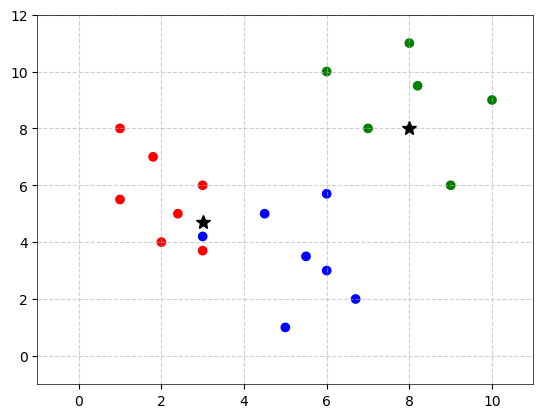

In [2]:
# lists of points
points = np.array([(1, 8), (2.4, 5), (3,6), (2,4), (1.8, 7), (3, 3.7), (1, 5.5),
                   (7,8), (9, 6), (10, 9), (6,10), (8,11), (8.2,9.5),
                   (5,1), (6, 3), (6, 5.7), (4.5,5), (5.5,3.5), (6.7, 2), (3,4.2)])

classes = np.array([0, 0, 0, 0, 0, 0, 0, 
                    1, 1, 1, 1, 1, 1, 
                    2, 2, 2, 2, 2, 2, 2])

unknown = np.array([(3, 4.7), (8,8)])

# plotting
colors = ['red','green','blue']
plt.scatter(*zip(*points), c=classes, cmap=mpl.colors.ListedColormap(colors))
plt.plot(*zip(*unknown), '*', color='black', markersize=10)
plt.xlim((-1,11))
plt.ylim((-1,12))
plt.grid(linestyle='--', alpha=0.6)

This same technique generalizes to objects that have more features (higher dimensionality). It's hard to plot a 10 dimensional point, but the distance function works in arbitrarily high dimensions, so you can still find nearest neighbors. 

Let's try using the python Nearest Neighbors function with the above example points.

In [4]:
# get the training data in the right format

# Create a nearest neighbors object
k = 5
nn = KNeighborsClassifier(n_neighbors=k)

# train the classifier using the labeled points
nn.fit(points, classes)

# predict the value of the unknown points. 
predictions = nn.predict(unknown)

# print the predictions
print([colors[i] for i in predictions])

['red', 'green']


Run the cell above with different values of $k$ to check your answers from above

## Application to IoT Privacy

In order to apply nearest neighbors to our IoT device network data we need to take the following steps:
1. Convert the lists of packets into points, with each point encapsulating the device's network activity at a particular time 
2. Associate each point with a label (the activity you were doing with the device at the time of the point). 
3. Divide the points into a training set and a test set and train a K-Nearest Neighbors classifier. In reality, "train" is a bit of a misnomer for nearest neighbors classifiers, because all that happens is that the points get stored for comparision. No math actually takes place.
4. Predict the labels of the test set using the classifier and calculate the accuracy of the predictions against the real labels.

#### 1. Import data and convert to points

In [5]:
pcap = pcap_to_pandas('example_pcaps/nestcam_live.pcap') # this can take a few minutes
pcap.head(n=4)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2016-07-29 15:10:03.220967,None,None,172.24.1.84,2.887254e+09,52.87.161.133,8.781582e+08,False,66,18:b4:30:54:a5:db,27162184033755,b8:27:eb:ed:34:f0,202481601426672,46110.0,443.0,TCP,1.469823e+09,0.000000
1,2016-07-29 15:10:03.260909,None,None,172.24.1.84,2.887254e+09,52.87.161.133,8.781582e+08,False,66,18:b4:30:54:a5:db,27162184033755,b8:27:eb:ed:34:f0,202481601426672,46110.0,443.0,TCP,1.469823e+09,0.039942
2,2016-07-29 15:10:03.271401,None,None,52.87.161.133,8.781582e+08,172.24.1.84,2.887254e+09,False,1506,b8:27:eb:ed:34:f0,202481601426672,18:b4:30:54:a5:db,27162184033755,443.0,46110.0,TCP,1.469823e+09,0.050434
3,2016-07-29 15:10:03.272394,None,None,52.87.161.133,8.781582e+08,172.24.1.84,2.887254e+09,False,1506,b8:27:eb:ed:34:f0,202481601426672,18:b4:30:54:a5:db,27162184033755,443.0,46110.0,TCP,1.469823e+09,0.051427


The data is currently stored as a list of packets, but we want it as points corresponding to time periods. 

Let's clean up the data a bit first. First, let's filter out all packets not sent by the device. Second, let's assume that the attacker is outside the home and only has access to IP traffic. Third, let's assume that the attacker only has access to the time each packet was sent and its length (this is a reasonable assumption for encrypted traffic, as we will discuss). 

In [7]:
# filter only packets sent by device
device_mac_address = '18:b4:30:54:a5:db' # device mac address as a string
device_packets = pcap.loc[pcap['mac_src'] == device_mac_address] # column name (as string) to compare to device_mac_addresses

# Remove all non-IP packets
ip_packets = device_packets.loc[device_packets['ip_src'].notnull()]
ip_packets = ip_packets.loc[ip_packets['ip_src'] != '0.0.0.0']
ip_packets = ip_packets.loc[ip_packets['ip_dst'] != '0.0.0.0']

# select only the 'time' and 'length' columns
time_packets = ip_packets[['time', 'length']]
time_packets.head(n=3)

,time,length
2,1.469823e+09,1506
3,1.469823e+09,1506
4,1.469823e+09,1506


Looks good, but why are the packet times just large numbers? These numbers are times in units of seconds since the "epoch" (January 1, 1970 at 00:00:00 GMT), a common format for computer timestamps. Let's convert them to normal-looking times.

In [8]:
time_packets["datetime"] = [datetime.fromtimestamp(t) for t in time_packets['time']]
time_packets.head(n=3)

,time,length,datetime
2,1.469823e+09,1506,2016-07-29 15:10:03.271401
3,1.469823e+09,1506,2016-07-29 15:10:03.272394
4,1.469823e+09,1506,2016-07-29 15:10:03.273265


Now let's convert the list of packets into send rates by calculating the total amount of data sent (sum of packet lengths) during equal length time windows. The 'send_rates()' function is defined in parse_pcap.py which we imported at the beginning of the notebook.

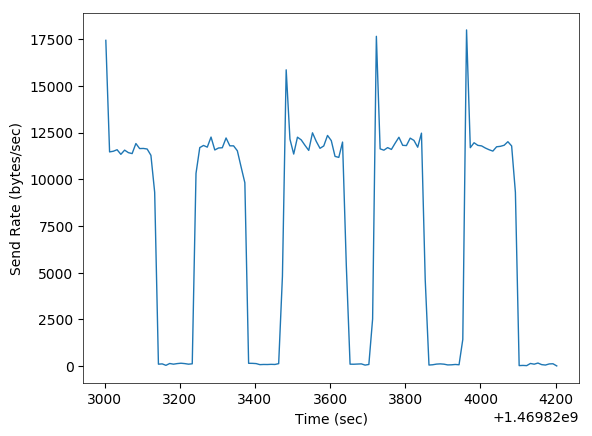

In [17]:
sampling_interval_sec = 10
rates, rate_times = send_rates(time_packets, sampling_interval_sec)

plt.plot(rate_times, rates)
plt.ylabel("Send Rate (bytes/sec)")
plt.xlabel("Time (sec)")
plt.show()

Try choosing different values for sampling_interval_sec and see how it affects the plots. What may be some benefits/drawbacks of having a small sampling interval? What may be benefits/drawbacks of having a large sampling interval? 

Next let's divide these rates into individual points we can associate with a specific activity by dividing the list of rates into longer time periods.

In [23]:
# function to divide send rates into larger chunks to act as points for kNN training
def rates_to_points(rates, times, samples_per_point):
    points = [rates[i:min(i+samples_per_point, rates.size-1)] for i in range(0, rates.size, samples_per_point)]
    times = [times[i] for i in range(0, times.size, samples_per_point)]
    return np.array(points[:-1]), np.array(times[:-1])
    
# number of send rate samples to include in each point. How many total seconds will each point represent? 
samples_per_point = 10

# perform the operation
points, point_times = rates_to_points(rates, rate_times,samples_per_point) 

# print the total number of points and an example
print(len(points))
print(points[0])

# print the total number of point_times and an example
print(len(point_times))
print(point_times[0])

12
[17436.  11466.8 11502.8 11584.  11336.6 11561.8 11428.2 11376.8 11915.
 11645.2]
12
1469823003.271401


Whew, now we have points and associated times. 

#### 2. Associate points with activity labels. 

First, read the labels from the text file

In [24]:
labels = pd.read_csv('example_pcaps/nestcam_live_labels.txt', header=None, names=["time", "activity"])
labels.head(n=10)

,time,activity
0,16:10:00,livestream
1,16:12:20,motion
2,16:14:00,livestream
3,16:16:20,motion
4,16:18:00,livestream
5,16:20:45,motion
6,16:22:00,livestream
7,16:24:15,motion
8,16:26:00,livestream
9,16:28:20,motion


We need to associate the labels with the points based on the timestamps

In [25]:
# convert time column into a full date and time. Open pcap file in Wireshark to find the date it was recorded
year = 2016
month = 7
day = 29

def convert_to_datetime(time):
    hour_min_sec = time.split(":")
    return datetime(year=year, month=month, day=day, 
                    hour=int(hour_min_sec[0]), minute=int(hour_min_sec[1]), second=int(hour_min_sec[2]))
                        
labels['datetime'] = labels['time'].apply(convert_to_datetime)

# convert datetime into a timestamp of seconds since epoch
tzlocal = datetime.now().astimezone().tzinfo

# BUG! Note Daylight Savings Time 
labels['timestamp'] = labels['datetime'].apply(lambda dt: dt.replace(tzinfo=tzlocal).timestamp()) - 3600

# Convert the activity names into class number labels
label_encoder = LabelEncoder()
labels['class'] = label_encoder.fit_transform(labels['activity']) # column name (as string) to convet to class numbers

# print the first few rows of the resulting labels 
labels.head(n=10)

,time,activity,datetime,timestamp,class
0,16:10:00,livestream,2016-07-29 16:10:00,1.469823e+09,0
1,16:12:20,motion,2016-07-29 16:12:20,1.469823e+09,1
2,16:14:00,livestream,2016-07-29 16:14:00,1.469823e+09,0
3,16:16:20,motion,2016-07-29 16:16:20,1.469823e+09,1
4,16:18:00,livestream,2016-07-29 16:18:00,1.469823e+09,0
5,16:20:45,motion,2016-07-29 16:20:45,1.469824e+09,1
6,16:22:00,livestream,2016-07-29 16:22:00,1.469824e+09,0
7,16:24:15,motion,2016-07-29 16:24:15,1.469824e+09,1
8,16:26:00,livestream,2016-07-29 16:26:00,1.469824e+09,0
9,16:28:20,motion,2016-07-29 16:28:20,1.469824e+09,1


In [26]:
# finally, map the labels to the points 
point_labels = []
label_row = 0

for t in point_times:
    # check if there are more activities
    if label_row < labels.shape[0] - 1:
        next_label_time = labels.iloc[label_row+1]['timestamp']
        
        # check if the next activity started before the current point
        if t >= next_label_time:
            label_row += 1
            
    # assign the current point to a class number
    current_class = labels.iloc[label_row]['class']
    point_labels.append(current_class)
    
# convert the result into a numpy array and print
point_labels = np.array(point_labels)
print(point_labels)

[0 0 1 0 1 0 0 1 0 1 0 1]


Whew, now we have both labels and points. As is often the case with AI, data preprocessing turns out to be the hardest step in the process. Since our points have more than three dimensions, they are hard to visualize. Let's try to get a sense of them by plotting them in 2D using a transformation called "Principle Component Analysis" (which we will explain on the board). 

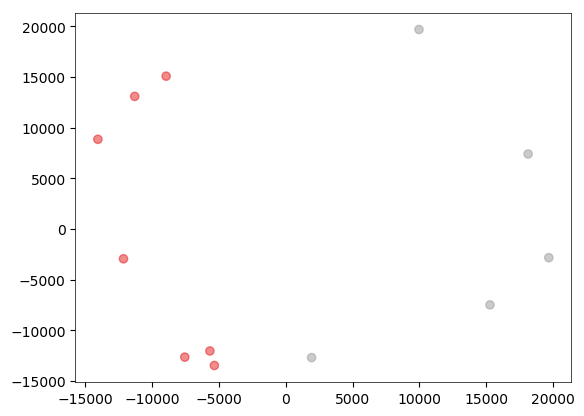

In [27]:
# Use PCA to convert data to 2 dimensions

pca = PCA(n_components=2) # n_components is number of dimensions of PCA result
points_2d = pca.fit_transform(points)

plt.scatter(*zip(*points_2d), c=point_labels, cmap=plt.get_cmap('Set1'), alpha=0.5)
plt.show()

This is a bit messy, but when you collapse high dimensional data into 2D, much of the structure of the data is lost. 
Nevertheless what is your impression of the data? Are points of the same class closer to each other than to points of other classes? How well do you think that the nearest neighbors classifier will work? 

#### 3. Train k-nearest-neighbors classifier

Let's divide the points into a training set and a test set. 

In [28]:
# the 'test_size' parameter determines what fraction of the data is reserved for testing
points_train, points_test, labels_train, labels_test = train_test_split(
    points, point_labels, test_size=0.20, random_state=1)

Now we can train the classifier on the training set.

In [29]:
# Create a nearest neighbors object
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# train the classifier using the labeled points
knn.fit(points_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

#### 4. Calculate accuracy on test set

Let's predict the labels for the test set points using the trained classifier and compare the predicted labels to the actual labels. Refer to the [accuracy_score documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to learn which arguments should be passed to 'accuracy_score()'

In [30]:
# predict the value of the test set points. 
labels_predictions = knn.predict(points_test)

# calculate the accuracy
accuracy = accuracy_score(labels_test,  labels_predictions)

# print the predictions and the accuracy
print(labels_predictions)
print(labels_test)
print(accuracy)

[0 0 1]
[1 0 1]
0.6666666666666666


## Discussion Questions

#### 1. Why is this attack a privacy risk? 

#### 2. How could we (IoT device programmers, network operators, etc.) protect people from this attack?

## Additional Exercises

#### 1. Adjust parameters to improve accuracy.

Now that we have a baseline accuracy, we can tweak the data preprocessing and classifier parameters to improve the accuracy. Look back through the code we've run so far. Which values have we set arbitrarily that could affect the results? Try changing these parameters and re-running the code to see how the classification accuracy is affected. Remember to re-run all of the cells below each change (or just restart the kernel and re-run all cells).  

#### 2. Run on your data from last week

Modify the notes you took about the activities you performed with your devices last week to match the format in  'example_pcaps/google_home_labels.txt'. Then try re-running the code above with your pcap file and labels file. You will likely need to change some of the parameters to optimize the results. How well does the k-NN algorithm do with your data? If the accuracy is worse than with the example data, think about why this might be the case. 

#### 3. Replace the KNearestClassifier above with a DecisionTreeClassifier _(advanced)_

You discussed decision trees in lecture today. How well does a decision tree perform on this task compared to K-NN? Replace the nearest neighbors classifier in the code above with a decision tree classifier and compare accuracies. In order to do this, you'll need to reference the DecisionTreeClassifier documentation at [http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)